In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

In [2]:
# PKLPATH = Path("/home/boittier/Documents/phd/ff_energy/pickles/")
# pd.read_csv(PKLPATH / "ELECmpol_water_cluster_lj_elec.csv")

#  Old FF objects

In [3]:
FFOBJ = pd.read_pickle(
    "/home/boittier/Documents/phd/ff_energy/pickles/ELECp_ions_ext_lj_intE_fitted.pkl")

In [4]:
FFOBJ.bounds

[(0.1, 5.5),
 (0.1, 5.5),
 (0.1, 5.5),
 (0.1, 5.5),
 (0.001, 0.1),
 (0.001, 0.1),
 (0.001, 0.1),
 (0.001, 0.1)]

In [5]:
FFOBJ.atom_types

['CLA', 'HT', 'OT', 'POT']

In [6]:
FFOBJ.get_best_parm()

array([1.89870963e+00, 2.49904612e+00, 1.46393915e+00, 9.00892334e-01,
       1.00000000e-03, 1.00067511e-03, 1.17324839e-03, 5.23727070e-03])

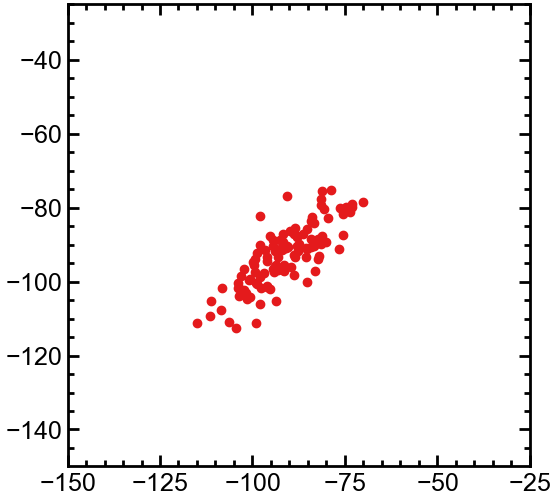

In [7]:
plt.scatter(FFOBJ.targets + FFOBJ.data.ELECp, 
            FFOBJ.opt_results_df[0][0] + FFOBJ.data.ELECp)
plt.xlim(-150, -25.0)
plt.ylim(-150, -25.0)
plt.gca().set_aspect('equal')

In [7]:
pd.DataFrame(FFOBJ.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
59,21.293474,2764,4132,0,True,Optimization terminated successfully.,"[1.8987096310556173, 2.4990461237807917, 1.463...","([[1.8987096310556173, 2.4990461237807917, 1.4..."
67,21.325718,1457,2170,0,True,Optimization terminated successfully.,"[1.8437766596387055, 2.5178014686773826, 1.463...","([[1.8437766596387055, 2.5178014686773826, 1.4..."
80,21.400326,1394,2155,0,True,Optimization terminated successfully.,"[0.49418883008838216, 1.5902162860805293, 2.52...","([[0.49418883008838216, 1.5902162860805293, 2...."
98,21.406542,1121,1773,0,True,Optimization terminated successfully.,"[0.49046442029146986, 1.5885663543745598, 2.52...","([[0.49046442029146986, 1.5885663543745598, 2...."
35,21.441751,1858,2808,0,True,Optimization terminated successfully.,"[0.48778869497028976, 1.593110347305247, 2.540...","([[0.48778869497028976, 1.593110347305247, 2.5..."
...,...,...,...,...,...,...,...,...
54,96.949478,457,721,0,True,Optimization terminated successfully.,"[0.1, 1.9152931995952827, 0.1, 0.1, 0.09999999...","([[0.1, 1.9152931995952827, 0.1, 0.1, 0.099999..."
62,126.291237,123,313,0,True,Optimization terminated successfully.,"[0.1553102393015169, 0.12751455672334974, 0.11...","([[0.1553102393015169, 0.12751455672334974, 0...."
33,126.291275,109,263,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.1, 0.1, 0.09888102637195578, 0.09...","([[0.1, 0.1, 0.1, 0.1, 0.09888102637195578, 0...."
21,126.291328,104,267,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.1, 0.1, 0.09565930501794412, 0.1,...","([[0.1, 0.1, 0.1, 0.1, 0.09565930501794412, 0...."


In [8]:
just_k_data = FFOBJ.data[FFOBJ.data["ion"] == "POT"].copy()
# just_cl_data

In [13]:
just_k_dists = {k:v for k, v in FFOBJ.dists.items() if k.upper() in list(FFOBJ.data[FFOBJ.data["ion"] == "POT"].index)}

In [11]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

NameError: name 'structs' is not defined

In [67]:
# data_.loc[names]
LJ_bound

[(0.05, 4.0), (0.05, 4.0), (1e-05, 1.0), (1e-05, 1.0)]

In [22]:
TESTCLA_ljpcff = FF(
    just_k_data, # pd.DataFrame
    just_k_dists, #
    FUNC, #
    [(0,1) for _ in range(6)], # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
TESTCLA_ljpcff.num_segments = len(just_k_data)
print("Nsegments", TESTCLA_ljpcff.num_segments)
TESTCLA_ljpcff.set_targets()

Atom types: ['HT', 'OT', 'POT']
Atom types: ['HT', 'OT', 'POT']
Atom types: ['HT', 'OT', 'POT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('HT', 'POT'), ('OT', 'OT'), ('OT', 'POT'), ('POT', 'POT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
37_14_POT_13_1    -95.994311
37_15_POT_15_1    -95.944443
37_16_POT_16_1    -83.251112
37_17_POT_17_1    -76.533498
37_1_POT_0_1      -85.320265
37_20_POT_21_1    -73.612697
37_21_POT_22_1    -88.527339
37_24_POT_25_1    -85.335727
37_25_POT_26_1    -84.159247
37_27_POT_28_1    -85.520558
37_28_POT_29_1    -87.911922
37_2_POT_1_1      -75.583245
37_32_POT_33_1    -74.652300
37_33_POT_34_1    -70.126190
37_35_POT_36_1    -72.979546
37_36_POT_37_1    -81.298711
37_4_POT_3_1      -92.053027
37_6_POT_5_1      -82.668180
37_9_POT_8_1      -79.453884
40_10_POT_10_1    -96.634439
40_11_POT_11_1    -97.636216
40_12_POT_12_1    -92.01

In [43]:
TESTCLA_ljpcff_fit = fit_repeat(TESTCLA_ljpcff,
             10,
             "test",
             loss="jax",
            quiet=False)

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ pot_test ELEC Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ pot_test ELEC Exact intE (jax_coloumb: False)>)
Optimizing LJ parameters...
function: get_loss_jax
bounds: [(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
maxfev: 10000
initial guess: [0.905698209214623, 2.571577731503749, 3.1558501548138653, 0.0568657013043485, 0.07140327786817799, 0.036749259788363624]
final_loss_fn:  21.608749389648438
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21.608749389648438
             x: [ 1.207e+00  1.003e+00  3.077e+00  6.536e-02  9.022e-02
                  1.000e-03]
           nit: 693
          nfev: 1154
 final_simplex: (array([[ 1.207e+00,  1.003e+00, ...,  9.022e-02,
                         1.000e-03],
                       [ 1.207e+00,  1.003e+00, ...,  9.022e-02,
                         1.000e-03],
                 

In [47]:
pd.DataFrame(TESTCLA_ljpcff_fit.opt_results).sort_values("fun").iloc[0].x

array([0.22039701, 1.72537567, 1.81636606, 0.1       , 0.1       ,
       0.09982985])

In [91]:
ljpcff_fit = fit_repeat(FFOBJ,
             2,
             "test",
             loss="jax",
            quiet=False)

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ ions_ext ELECp Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ ions_ext ELECp Exact intE (jax_coloumb: False)>)
Optimizing LJ parameters...
function: get_loss_jax
bounds: [(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
maxfev: 10000
initial guess: [3.4652391246397944, 3.2888019491247564, 4.372501797271171, 3.0193531467534083, 0.06343752992218595, 0.015743305921289155, 0.08933572208943609, 0.04627245991088882]
final_loss_fn:  31.59855079650879
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 31.59855079650879
             x: [ 1.000e-01  6.951e-01  7.628e-01  2.662e+00  9.900e-02
                  1.000e-03  9.981e-02  1.000e-03]
           nit: 743
          nfev: 1180
 final_simplex: (array([[ 1.000e-01,  6.951e-01, ...,  9.981e-02,
                         1.000e-03],
                       [ 1.0

(array([ 4.,  8., 17., 27., 23., 10.,  9.,  6.,  6.,  4.]),
 array([-2.0932007,  0.5673912,  3.227983 ,  5.888575 ,  8.549167 ,
        11.209759 , 13.870351 , 16.530943 , 19.191534 , 21.852127 ,
        24.512718 ], dtype=float32),
 <BarContainer object of 10 artists>)

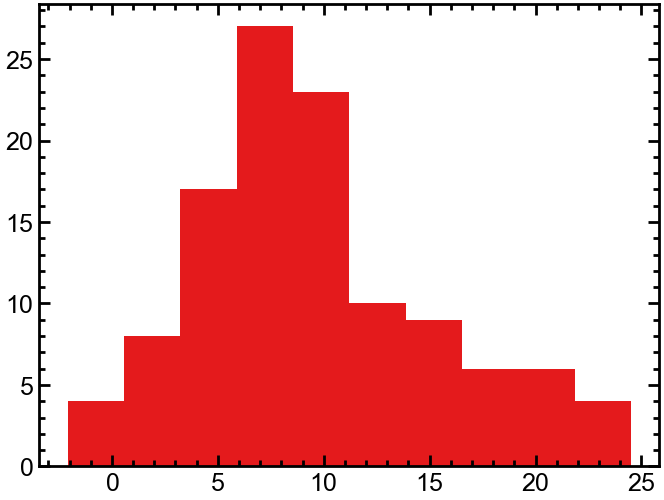

In [9]:
plt.hist(FFOBJ.targets)

# Mike's Data

In [58]:
polE = [-0.414108045672691,
-3.18751925572136,
-0.135589440516043,
-6.50420378424246,
-5.08720706684926,
-0.847746264614244,
-2.88719922192413,
1.23023692162019,
2.34732370863043,
2.42284220912128,
0.918818910952268,
-7.02516712813826,
-2.94324580629078,
-1.90211349555901,
1.40281740816175,
0.533864995459993,
-3.80231412297786,
-2.13240211849146,
0.085510269966079,
-0.34770746468962,
# 2.12613296059692,
# -0.247729935513746,
# 1.47343723895722,
# 3.18660071579751,
# -1.45335918792424,
# 1.25973868174952,
# 1.6957922311253,
# -1.51233214772702,
# 1.37607082667697,
# 3.27774245735662,
# -2.53773459790372
       ]

In [59]:
ciE = [-172.294748700473,
-162.753901968924,
-161.600709456013,
-177.597983623278,
-195.571327086928,
-157.175740278685,
-173.45650867918,
-179.84902864648,
-160.935151740573,
-167.504171516421,
-163.12057492246,
-188.237766971484,
-177.5333343772,
-173.981065221248,
-178.015983956155,
-177.969325403712,
-178.345772709696,
-173.566174889506,
-151.980813822351,
-144.433456643724,
# -156.096085287681,
# -164.732736539375,
# -173.57415384982,
# -157.751438562752,
# -176.33060276309,
# -162.167001889172,
# -141.865838628083,
# -144.00915397662,
# -156.640545132153,
# -159.762448589636,
# -160.441112581321,
      ]

#  New structures

In [15]:
data = pd.read_pickle(
    "/home/boittier/Documents/phd/ff_energy/pickles/pot_test_pbe0dz_pc.pkl")

In [16]:
data_ = data.data
data_.index = data_.KEY

In [17]:
structure = "pot_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 28 28


In [18]:
data_.sort_index()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
POT_0_0,21.82734,-94.51291,19.53986,POT_0_0,-1515.867824,13,-1515.992999,-78.547563,-951290.154858
POT_10_10,21.21243,-89.48986,8.94447,POT_10_10,-1515.872198,13,-1516.013250,-88.510258,-951302.862427
POT_11_11,19.61882,-86.16030,12.63596,POT_11_11,-1515.874577,13,-1515.993924,-74.890444,-951290.735235
POT_12_12,18.63329,-91.47022,12.44096,POT_12_12,-1515.874702,13,-1516.012145,-86.245995,-951302.168848
POT_13_13,20.18720,-88.13878,16.86759,POT_13_13,-1515.875294,13,-1516.011288,-85.336260,-951301.631053
POT_14_14,16.41243,-92.37765,16.50018,POT_14_14,-1515.879971,13,-1516.014047,-84.133312,-951303.362616
POT_15_15,20.45611,-87.91368,12.31802,POT_15_15,-1515.871409,13,-1516.012076,-88.269021,-951302.125488
POT_16_16,19.64130,-96.85808,18.19235,POT_16_16,-1515.867367,13,-1516.003633,-85.507587,-951296.827725
POT_17_17,19.51778,-96.81038,18.65028,POT_17_17,-1515.869895,13,-1516.009931,-87.873613,-951300.780027


In [65]:
names = ["CLA_0_0",
"CLA_1_1",
"CLA_2_2",
"CLA_3_3",
"CLA_4_4",
"CLA_5_5",
"CLA_6_6",
"CLA_7_7",
"CLA_8_8",
"CLA_9_9",
"CLA_10_10",
"CLA_11_11",
"CLA_12_12",
"CLA_13_13",
"CLA_14_14",
"CLA_15_15",
"CLA_16_16",
"CLA_17_17",
"CLA_18_18",
"CLA_19_19",
# "CLA_20_20",
# "CLA_21_21",
# "CLA_22_22",
# "CLA_23_23",
# "CLA_24_24",
# "CLA_25_25",
# "CLA_26_26",
# "CLA_27_27",
# "CLA_28_28",
# "CLA_29_29",
# "CLA_30_30",
        ]

In [19]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [137]:
# data_.loc[names]
LJ_bound

[(0.05, 4.0), (0.05, 4.0), (1e-05, 1.0), (1e-05, 1.0)]

In [24]:
ljpcff = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    [(0,1) for _ in range(6)], # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(data_)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['HT', 'OT', 'POT']
Atom types: ['HT', 'OT', 'POT']
Atom types: ['HT', 'OT', 'POT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('HT', 'POT'), ('OT', 'OT'), ('OT', 'POT'), ('POT', 'POT')]
setting random parameters
Getting 6 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
POT_0_0     -78.547563
POT_10_10   -88.510258
POT_11_11   -74.890444
POT_12_12   -86.245995
POT_13_13   -85.336260
POT_14_14   -84.133312
POT_15_15   -88.269021
POT_16_16   -85.507587
POT_17_17   -87.873613
POT_18_18   -85.280481
POT_19_19   -75.598920
POT_1_1     -67.456742
POT_20_20   -70.913662
POT_21_21   -92.046457
POT_22_22   -94.134430
POT_23_23   -82.671650
POT_24_24   -81.828355
POT_25_25   -90.533322
POT_26_26   -79.435994
POT_27_27   -72.472769
POT_2_2     -81.720362
POT_3_3     -74.630676
POT_4_4     -70.134956
POT_5_5     -85.330807
POT_6_6     -72.997229
POT_7_7     -81.283563
POT_8_8     -90.697872
POT_9_9     

In [25]:
# a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
# a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [26]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

[1.89870963e+00, 2.49904612e+00, 1.46393915e+00, 9.00892334e-01,
1.00000000e-03, 1.00067511e-03, 1.17324839e-03, 5.23727070e-03]

[1.89870963,
 2.49904612,
 1.46393915,
 0.900892334,
 0.001,
 0.00100067511,
 0.00117324839,
 0.0052372707]

In [27]:
# tip3
# a,b,c = ljpcff.eval_jax([ 
#         0.2245,
#         1.7682, 
#         0.0460, 
#         0.1521, 
# ])
a,b,c = ljpcff.eval_jax(
[
1.000e-01,  3.240e-01,  3.413e+00,  
9.753e-02,  2.838e-02,  8.480e-02,
]
                         )

In [28]:
a

Array([10.711815 ,  6.555228 , 12.302761 ,  8.170876 , 10.129478 ,
       10.35882  ,  5.7982407,  5.8423777, 12.934602 , 11.529826 ,
       12.069498 , 13.998847 ,  5.2698836,  4.195812 , 12.198406 ,
       13.876441 ,  9.359184 ,  6.2266154, 10.093526 , 10.091681 ,
        7.5411205,  9.377902 , 11.504253 , 10.208454 ,  7.13968  ,
        9.722084 ,  8.499255 , 13.588874 ], dtype=float32)

In [38]:
a_,b_,c_ = FFOBJ.eval_jax([1.89870963e+00, 2.49904612e+00, 1.46393915e+00, 9.00892334e-01,
       1.00000000e-03, 1.00067511e-03, 1.17324839e-03, 5.23727070e-03])
a_

Array([22.574469 ,  9.074636 ,  4.4700484, 10.86132  ,  5.4801106,
        9.125593 ,  6.385825 , 10.304658 , 12.070015 , 11.072428 ,
       10.490596 ,  9.2500725,  6.8061547,  5.4968524,  6.5320992,
       11.321433 ,  7.654702 ,  8.20705  ,  7.861574 , 10.807115 ,
        8.380394 , 10.494856 ,  7.2589536,  7.0949106,  9.432262 ,
        9.39661  ,  9.156191 , 13.356741 , 10.230818 ,  5.528767 ,
        7.0893636, 11.368005 , 10.532068 ,  8.139096 ,  8.087753 ,
        7.9359336,  7.63169  , 10.937242 , 19.063187 ,  7.53798  ,
        6.30353  ,  4.741537 ,  7.581398 ,  5.7388086, 12.800904 ,
       10.104998 ,  9.749247 ,  7.861291 ,  7.0116105, 10.876724 ,
       10.852463 ,  5.640131 , 23.695873 ,  7.0165815, 10.525339 ,
       12.360449 , 12.818221 ,  8.865872 ,  9.8312645,  8.041536 ,
       11.501702 ,  5.6431456, 11.104328 , 10.7884   ,  5.6160274,
        5.5148787,  8.847982 , 16.636469 , 11.564121 ,  4.6252246,
        9.637035 , 12.14283  , 10.477562 ,  7.9174285, 11.5150

In [39]:
ljpcff.targets

Array([15.965347  ,  0.979599  , 11.269859  ,  5.224228  ,  2.8025208 ,
        8.244339  , -0.35533905, 11.350494  ,  8.936768  ,  8.805428  ,
       15.500168  , 20.473907  , 11.582283  ,  5.313286  ,  2.0133286 ,
       14.557045  , 16.18808   , 11.797844  ,  6.1699295 ,  4.6670303 ,
        3.260933  ,  8.710617  , 15.735001  , 10.333847  ,  8.1755905 ,
        9.720345  ,  2.6363754 , 13.243988  ], dtype=float32)

(array([2., 4., 3., 1., 6., 5., 1., 5., 0., 1.]),
 array([-0.35533905,  1.7275856 ,  3.8105102 ,  5.893435  ,  7.9763594 ,
        10.059284  , 12.142209  , 14.225134  , 16.308058  , 18.390984  ,
        20.473907  ], dtype=float32),
 <BarContainer object of 10 artists>)

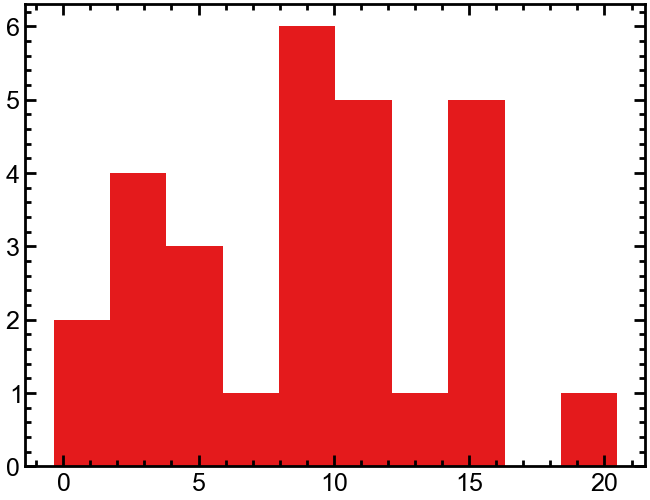

In [30]:
plt.hist(ljpcff.targets)

In [31]:
# datacopy.loc[names]

In [32]:
datacopy = ljpcff.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
POT_0_0,21.82734,-94.51291,19.53986,POT_0_0,-1515.867824,13,-1515.992999,-78.547563,-951290.154858,0.0,10.711815,15.965347
POT_10_10,21.21243,-89.48986,8.94447,POT_10_10,-1515.872198,13,-1516.013250,-88.510258,-951302.862427,0.0,6.555228,0.979599
POT_11_11,19.61882,-86.16030,12.63596,POT_11_11,-1515.874577,13,-1515.993924,-74.890444,-951290.735235,0.0,12.302761,11.269859
POT_12_12,18.63329,-91.47022,12.44096,POT_12_12,-1515.874702,13,-1516.012145,-86.245995,-951302.168848,0.0,8.170876,5.224228
POT_13_13,20.18720,-88.13878,16.86759,POT_13_13,-1515.875294,13,-1516.011288,-85.336260,-951301.631053,0.0,10.129478,2.802521
POT_14_14,16.41243,-92.37765,16.50018,POT_14_14,-1515.879971,13,-1516.014047,-84.133312,-951303.362616,0.0,10.358820,8.244339
POT_15_15,20.45611,-87.91368,12.31802,POT_15_15,-1515.871409,13,-1516.012076,-88.269021,-951302.125488,0.0,5.798241,-0.355339
POT_16_16,19.64130,-96.85808,18.19235,POT_16_16,-1515.867367,13,-1516.003633,-85.507587,-951296.827725,0.0,5.842378,11.350494
POT_17_17,19.51778,-96.81038,18.65028,POT_17_17,-1515.869895,13,-1516.009931,-87.873613,-951300.780027,0.0,12.934602,8.936768


In [33]:
datacopy = datacopy.loc[names]
datacopy["EPOL"] = polE
datacopy["ECI"] = ciE

NameError: name 'names' is not defined

In [34]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
POT_0_0,21.82734,-94.51291,19.53986,POT_0_0,-1515.867824,13,-1515.992999,-78.547563,-951290.154858,0.0,10.711815,15.965347
POT_10_10,21.21243,-89.48986,8.94447,POT_10_10,-1515.872198,13,-1516.013250,-88.510258,-951302.862427,0.0,6.555228,0.979599
POT_11_11,19.61882,-86.16030,12.63596,POT_11_11,-1515.874577,13,-1515.993924,-74.890444,-951290.735235,0.0,12.302761,11.269859
POT_12_12,18.63329,-91.47022,12.44096,POT_12_12,-1515.874702,13,-1516.012145,-86.245995,-951302.168848,0.0,8.170876,5.224228
POT_13_13,20.18720,-88.13878,16.86759,POT_13_13,-1515.875294,13,-1516.011288,-85.336260,-951301.631053,0.0,10.129478,2.802521
POT_14_14,16.41243,-92.37765,16.50018,POT_14_14,-1515.879971,13,-1516.014047,-84.133312,-951303.362616,0.0,10.358820,8.244339
POT_15_15,20.45611,-87.91368,12.31802,POT_15_15,-1515.871409,13,-1516.012076,-88.269021,-951302.125488,0.0,5.798241,-0.355339
POT_16_16,19.64130,-96.85808,18.19235,POT_16_16,-1515.867367,13,-1516.003633,-85.507587,-951296.827725,0.0,5.842378,11.350494
POT_17_17,19.51778,-96.81038,18.65028,POT_17_17,-1515.869895,13,-1516.009931,-87.873613,-951300.780027,0.0,12.934602,8.936768


In [147]:
# np.sqrt(calc_rmse(
#     ljpcff.data.intE,
#     a + ljpcff.data.ELEC
# ))

np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ECI + datacopy.EPOL
))


58.675255322639565

In [35]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC
))

4.6749056463261605

In [36]:
np.std(datacopy.intE - (datacopy.fitE + datacopy.ELEC))

4.639882599079641

In [40]:
np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELECp))

4.614485217401197

In [41]:
np.std(FFOBJ.data.intE - ( a_ + FFOBJ.data.ELECp))

4.614295452128199

Text(0, 0.5, 'FF ENERGY [kcal/mol]')

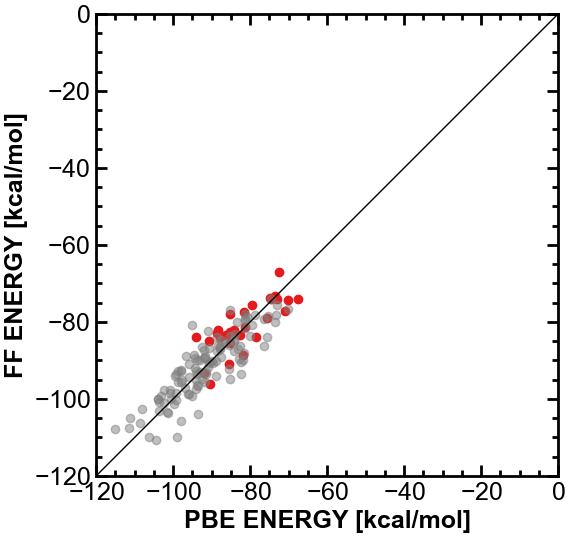

In [42]:
plt.scatter(
          datacopy.intE,
    datacopy.fitE + datacopy.ELEC
           )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELECp,  c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
# plt.savefig("water_ci_test.png")

In [35]:
datacopy.ELEC + datacopy.EPOL

KEY
test0    -118.862363
test1    -127.525264
test2    -123.624245
test3    -123.658581
test4     -94.142098
test5    -138.048353
test6    -140.140754
test7    -102.955511
test8    -128.956009
test9    -119.479721
test10   -132.643511
test11   -124.962830
test12   -102.917665
test13   -116.993678
test14   -111.887659
test15   -112.025413
test16   -130.456218
test17    -98.583588
test18   -116.141396
test19   -124.857491
dtype: float64

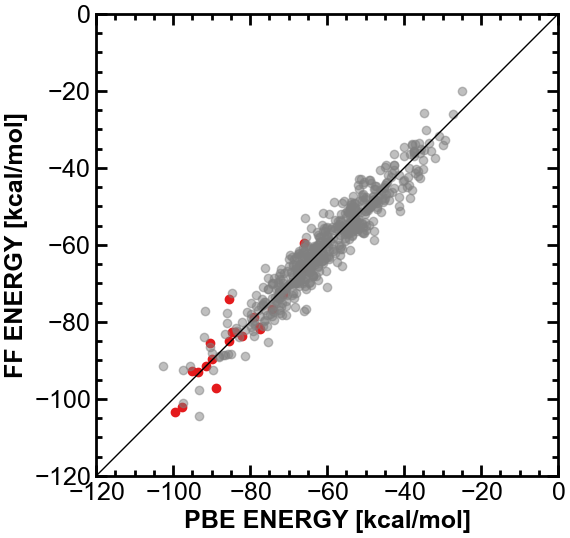

In [37]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ECI + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELECpol, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pol_test.png")